# Loading the model and getting image components:
## Before this prediction part, I ran:
```flow --model cfg/tiny-yolo-voc-3c.cfg --load bin/tiny-yolo-voc.weights --train --annotation train/Annotations --dataset train/Images --gpu 0.5```
[using 50% of my gpu]

to train the model. It creates checkpoints in the ckpt folder. 

Depending on the number of labels, the config file (cfg/tiny-yolo-voc-3c.cfg here) has to be changed using instructions from the darkflow README [here](https://github.com/thtrieu/darkflow)

I also referred to [this](https://towardsdatascience.com/yolov2-to-detect-your-own-objects-soccer-ball-using-darkflow-a4f98d5ce5bf) article and [this](https://www.youtube.com/watch?v=eFJOGsQ_YTA) video.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2

/home/rohan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
options = {"model": "cfg/tiny-yolo-voc-3c.cfg",
           "load": -1, # loads from prev checkpoint
           "gpu": 0.5}


tfnet2 = TFNet(options)

Parsing cfg/tiny-yolo-voc-3c.cfg
Loading None ...
Finished in 8.296966552734375e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13,

In [3]:
tfnet2.load_from_ckpt()

Loading from ./ckpt/tiny-yolo-voc-3c-750
INFO:tensorflow:Restoring parameters from ./ckpt/tiny-yolo-voc-3c-750


In [12]:
def boxing(original_img , predictions):
    '''returns list of the images that we crop using bounding boxes'''
    newImage = np.copy(original_img)
    L=[]
    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0.3: # can change this to whatever percent depending on the minimim confidence you want
#             newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
#             newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
            L.append(newImage[top_y:btm_y,top_x:btm_x])
    if len(L)==5:
        return L
    else:
        print('not all have confidence>0.3, error.')
        return -1

def boxing_original(original_img , predictions):
    '''draws bounding boxes on the original card'''
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0.3: # can change this to whatever percent depending on the minimim confidence you want
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
        
    return newImage

[{'bottomright': {'x': 214, 'y': 218},
  'confidence': 0.88680685,
  'label': 'name',
  'topleft': {'x': 41, 'y': 181}},
 {'bottomright': {'x': 201, 'y': 314},
  'confidence': 0.8091386,
  'label': 'text',
  'topleft': {'x': 51, 'y': 227}},
 {'bottomright': {'x': 71, 'y': 92},
  'confidence': 0.97362703,
  'label': 'cost',
  'topleft': {'x': 17, 'y': 35}},
 {'bottomright': {'x': 68, 'y': 337},
  'confidence': 0.8909148,
  'label': 'attack',
  'topleft': {'x': 21, 'y': 293}},
 {'bottomright': {'x': 234, 'y': 338},
  'confidence': 0.9500023,
  'label': 'health',
  'topleft': {'x': 193, 'y': 282}}]


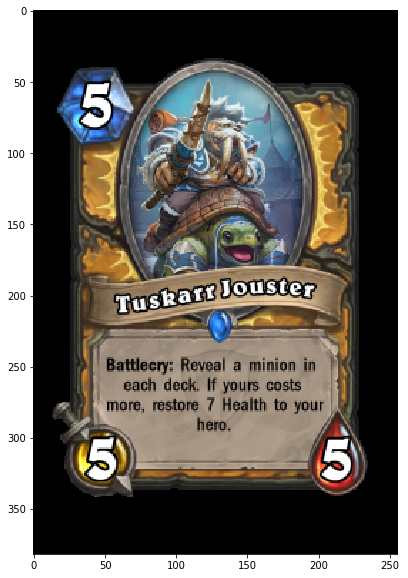

In [36]:
import pprint as pp
# a random image that we chose, to show the workflow

original_img = cv2.imread("train/Images/AT_104.png")

#LIMITATIONS (uncomment to see)
# original_img = cv2.imread("customCards/customCard.png")
# original_img = cv2.imread("customCards/customCard5.png")

original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(original_img)
results = tfnet2.return_predict(original_img)
pp.pprint(results)

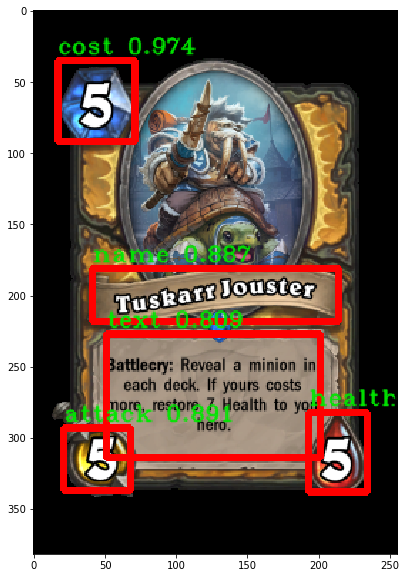

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(boxing_original(original_img,results))

In [6]:
name,text,cost,attack,health = boxing(original_img, results)
fig, ax = plt.subplots(1,5,figsize=(20, 10))
ax[0].imshow(name)
ax[1].imshow(text)
ax[2].imshow(cost)
ax[3].imshow(attack)
ax[4].imshow(health)

not all have confidence>0.3, error.


TypeError: 'int' object is not iterable

# Loading the neural network for digit classification

Here, we load the pretrained model, which was trained on 103,520 images to recognize digits in our cards.

`model_structure.json` contains the structure data of the exported neural network.

`model_weights.h5` contains the weights of the exported neural network.

Once loaded, the model requires re-compilation.

Referred [here](https://www.kaggle.com/juanlebk/apply-cnn-for-digit-recognition-with-keras), [here](https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a), [here](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/) and [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)

In [20]:
from PIL import Image
from keras.models import model_from_json
import tensorflow as tf

json_file = open('model_structure.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights('model_weights.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Using TensorFlow backend.


In [21]:
def predict_digit(image): # takes in image npArray
    img=Image.fromarray(image)
    img = img.convert('RGB')
    img=img.resize((50,50))
    img=np.array(img)
    img=img.reshape(1,50,50,3)
    return np.argmax(model.predict(img)[0]) 


In [100]:
predict_digit(health)

5

# Loading the text recognition stuff:
Using Google cloud vision API to get the text. 
The setup process included downloading the `apikey.json` file from the GCP console and adding it to PATH under the variable name `GOOGLE_APPLICATION_CREDENTIALS`. (adding it to `~/.bashrc` on linux based systems)

Also need to `pip install google-cloud` and other dependancies required.

Referred to [this](https://www.youtube.com/watch?v=nMY0qDg16y4) video, and [this](https://cloud.google.com/vision/docs/detecting-text#vision-text-detection-python) and [this](https://cloud.google.com/vision/docs/detecting-text#vision-text-detection-python) link.

In [22]:
import io
from google.cloud import vision

In [23]:
def detect_text(np_image): # image is a numpy array
    """Detects text in the image, returns it as a string"""    
    client = vision.ImageAnnotatorClient()
    success, content = cv2.imencode('.png', np_image)
    content = content.tobytes()
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    try:
        text_response = response.text_annotations
        text_content = text_response[0].description 
        return text_content
    except:
        return ''

In [93]:
# name, text have textual content
print(detect_text(name))
print(detect_text(text))

Tuskarr Jouster

Battlecry: Reveal a minion in
each deck. If yours costs
more, restore 7 Health to you
hero.



# Let's see the output for a few randomly chosen cards!

In [24]:
import os, random
home_folder='train/Images/'
files=os.listdir(home_folder)

In [25]:
def printCard(fileName,original_img, results, name_text, text_text,cost_num, attack_num,health_num):
    print(f'-----------RESULTS FOR CARD {fileName}------------')
    print(f'Name: {name_text}\nText: {text_text}\nCost: {cost_num}\nAttack: {attack_num}\nHealth: {health_num}')
    fig, ax = plt.subplots(1,2,figsize=(15, 7))    
    ax[0].imshow(original_img)
    ax[1].imshow(boxing_original(original_img,results))

In [26]:
def randomCardInfo():
    # loading random image
    random_index=random.randint(0,len(files)-1)
    original_img = cv2.imread(home_folder+files[random_index])
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    #getting bounding boxes and components
    results = tfnet2.return_predict(original_img)
    name,text,cost,attack,health = boxing(original_img, results)
    #getting numeric data
    cost_num, attack_num,health_num = predict_digit(cost),predict_digit(attack),predict_digit(health)
    #getting textual data
    name_text, text_text = detect_text(name), detect_text(text)
    printCard(files[random_index],original_img, results, name_text, text_text,cost_num, attack_num,health_num)
    

-----------RESULTS FOR CARD EX1_577.png------------
Name: The Beast

Text: Deathrattle: Summon a
3/3 Finkle Einhorn for your
opponent.

Cost: 6
Attack: 9
Health: 7


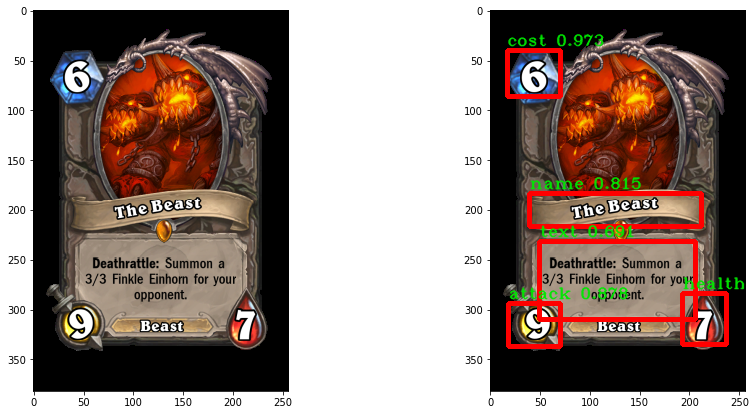

In [39]:
randomCardInfo()